# Sentiment Analysis 2

## Table of Contents:
Sentiment Analysis of Movie Reviews:
1. EDA
2. Data Preprocessing
3. Feature Extraction
4. ML modelling

### Importing Libraries

In [187]:
# Linear algebra
import numpy as np
# EDA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# NLTK libraries
import nltk
# nltk.download('all')    # After running all, comment out this line to stop redownloading nltk every time
# Stopwords
from nltk.corpus import stopwords
# Stemmer & Lemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
# Wordcloud
from wordcloud import WordCloud,STOPWORDS
# Tokenizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
# RE
import re,string,unicodedata
# Bag of Words
from textblob import TextBlob
from textblob import Word
# Feature Extraction
from sklearn.model_selection import train_test_split, cross_val_score,StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
# ML models
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
# Metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Web Scraping tool
from bs4 import BeautifulSoup

### Importing dataset

In [188]:
data = pd.read_csv('datasets/IMDB.csv')

In [189]:
# Extend the dataframe display size
pd.options.display.max_colwidth = 110

### Inspecting dataset

In [190]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are ...,positive
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fas...,positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air condition...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents a...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a v...",positive


In [191]:
data.shape

(50000, 2)

## 1. EDA

In [192]:
# Summary of the dataset
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stim...,positive
freq,5,25000


In [193]:
# Counting sentiments
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

## 2. Data Preprocessing


In [194]:
# Quick visualisation of dataset (First 5 + Last 5 rows)
data

,review,sentiment
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are ...,positive
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fas...,positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air condition...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents a...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a v...",positive
...,...,...
49995,"I thought this movie did a down right good job. It wasn't as creative or original as the first, but who wa...",positive
49996,"Bad plot, bad dialogue, bad acting, idiotic directing, the annoying porn groove soundtrack that ran contin...",negative
49997,"I am a Catholic taught in parochial elementary schools by nuns, taught by Jesuit priests in high school & ...",negative
49998,I'm going to have to disagree with the previous comment and side with Maltin on this one. This is a second...,negative


In [195]:
# Make a copy of the 'data' dataframe to work off from
data_IMDB = data.copy()

In [196]:
data_IMDB

,review,sentiment
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are ...,positive
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fas...,positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air condition...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents a...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a v...",positive
...,...,...
49995,"I thought this movie did a down right good job. It wasn't as creative or original as the first, but who wa...",positive
49996,"Bad plot, bad dialogue, bad acting, idiotic directing, the annoying porn groove soundtrack that ran contin...",negative
49997,"I am a Catholic taught in parochial elementary schools by nuns, taught by Jesuit priests in high school & ...",negative
49998,I'm going to have to disagree with the previous comment and side with Maltin on this one. This is a second...,negative


### Tokenizing

In [197]:
# Initialize the tokenizer
tokenizer = ToktokTokenizer()

# Setting English stopwords
stopword = nltk.corpus.stopwords.words('english')

In [198]:
# Example text to tokenize
text = "This is an example sentence for tokenization."

# Tokenize the text
tokens = tokenizer.tokenize(text)

# # Print the tokens
print(tokens)

['This', 'is', 'an', 'example', 'sentence', 'for', 'tokenization', '.']


### Text Processor

In [199]:
# Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

In [200]:
# Example of our 3 defined functions
html_text = "<p>This is <b>bold</b> and <i>italic</i>.</p>"
plain_text = strip_html(html_text)
print(plain_text)

input_text = "This is [some text] with [multiple] sets of [square brackets]."
result = remove_between_square_brackets(input_text)
print(result)

input_text = "Hello, @world! 123"
result2 = remove_special_characters(input_text)
print(result2)

This is bold and italic.
This is  with  sets of .
Hello world 123


In [201]:
# Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    return text

# Apply function on review column
data_IMDB['review'] = data_IMDB['review'].apply(denoise_text)

In [202]:
data_IMDB['review']

0        One of the other reviewers has mentioned that after watching just 1 Oz episode youll be hooked They are ri...
1        A wonderful little production The filming technique is very unassuming very oldtimeBBC fashion and gives a...
2        I thought this was a wonderful way to spend time on a too hot summer weekend sitting in the air conditione...
3        Basically theres a family where a little boy Jake thinks theres a zombie in his closet  his parents are fi...
4        Petter Matteis Love in the Time of Money is a visually stunning film to watch Mr Mattei offers us a vivid ...
                                                             ...                                                      
49995    I thought this movie did a down right good job It wasnt as creative or original as the first but who was e...
49996    Bad plot bad dialogue bad acting idiotic directing the annoying porn groove soundtrack that ran continuall...
49997    I am a Catholic taught in parochial ele

In [203]:
# Lemmatizing the text
def simple_lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = ' '.join({lemmatizer.lemmatize(word) for word in text.split()})
    return text

# Apply function on review column
data_IMDB['review'] = data_IMDB['review'].apply(simple_lemmatize)

In [204]:
# Example of lemmatizing text using sample sentence
input_text = "I am running and eating. The cars are running fast."
lemmatized_text = simple_lemmatize(input_text)
print(lemmatized_text)

are running car and eating. The am fast. I


### Initial Data-Preprocessing Verdict
Lemmatizer is not as accurate as we want it to be
- Sentences are garbled and in a mess

### Part-Of-Speech (POS) tagging
Implement Part-Of-Speech (POS) tagging to improve accuracy.

This helps the algorithm understand the grammatical structure and meaning of a text.

For example, consider the sentence: "The cat is sleeping on the mat."

POS tagging would assign the following tags:
- "The" - determiner (DT)
- "cat" - noun (NN)
- "is" - verb (VBZ)
- "sleeping" - verb (VBG)
- "on" - preposition (IN)
- "the" - determiner (DT)
- "mat" - noun (NN)

In [205]:
from nltk import pos_tag

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Function to process the pos_tag
def get_wordnet_pos(tag):
    if tag.startswith('N'):
        return 'n'  # Noun
    elif tag.startswith('V'):
        return 'v'  # Verb
    elif tag.startswith('R'):
        return 'r'  # Adverb
    elif tag.startswith('J'):
        return 'a'  # Adjective
    else:
        return 'n'  # Default to noun for unknown or uncategorized words

# Redefining the lemmatizer function
def simple_lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tags]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

[nltk_data] Downloading package punkt to /Users/jarylljw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jarylljw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jarylljw/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [206]:
# Test if the new function works as intended
input_text = "I am running and eating. The cars are running fast."
lemmatized_text = simple_lemmatize(input_text)
print(lemmatized_text)

I be run and eat . The car be run fast .


In [207]:
# # Can we apply the new function on review column?
# data_IMDB['review'] = data_IMDB['review'].apply(simple_lemmatize)
# # We are not going to do it this way; computationally expensive, time consuming

In [208]:
# Set stopwords to English
stop = set(stopwords.words('english'))
print(stop)

# Removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# Example to test out our stopword-removing function
input_text = "This is an example sentence with some stopwords."
filtered_text = remove_stopwords(input_text, is_lower_case=True)
print(filtered_text)

{'theirs', "aren't", 'yourself', 'their', 'ourselves', "wasn't", 'it', 'up', 'you', 'where', 'the', "shouldn't", 'our', 'itself', 'should', 'or', 'both', 'weren', 'hasn', 'his', 'very', 'couldn', 'when', 'why', 'for', 'to', 'each', 'after', 'had', "she's", 'between', 'shan', 'were', 'its', 'd', 'few', "it's", 'until', 'more', 'an', 'me', 'has', "mustn't", 'ma', 'against', 'ain', 'now', 'into', 'aren', 'hadn', 'any', 've', 't', 'm', 'from', 'will', 'being', 'how', 'is', 'a', 'herself', "should've", 'won', 'further', 'in', 'her', 'over', 'once', 'same', 'she', 'some', "haven't", 'are', 'have', 'him', 'again', "wouldn't", 'with', "you'll", 'no', 'he', 'other', 'here', "shan't", 'been', 'do', 'doing', 'under', 'wasn', 'did', 'than', 'whom', 're', "you're", 'mightn', "hasn't", "weren't", "you'd", "doesn't", 'but', 'don', 'mustn', 'not', 'at', 'shouldn', 'these', 'which', 'below', 'out', "that'll", "you've", 'yourselves', 'while', 'having', 'above', "mightn't", 'yours', 'themselves', "hadn't

In [209]:
# Apply function on 'review' column
data_IMDB['review'] = data_IMDB['review'].apply(remove_stopwords)

### Text Normalisation

In [210]:
# Set a variable for the normalized dataframe and add the data_IMDB
norm_data_IMDB = data_IMDB.copy()
norm_data_IMDB

,review,sentiment
0,wouldnt watched moreso awayI become thing graphic nickname Italians dodgy away set classic City violence O...,positive
1,reference Williams Orton thing chosen Halliwells comforting extremely Sheen set mural entry play well see ...,positive
2,Ive Devil time still young summer killer average lighthearted style spend thought Woody conditioned disapp...,positive
3,watched think divorcing similar become going thriller Jake youre must Basically instead opera film well sp...,negative
4,time contact people next work loneliness thing relation Time Stylishly best transfer soul Carol Kane stage...,positive
...,...,...
49995,think yr people seen involved job going become wait horribleCatwoman thought masterpiece soul last even cl...,positive
49996,time similar spoof copy annoying overacted cannot bad directing could soundtrack Dolls ran thousand Janis ...,negative
49997,bullet still people toSo thing besides fake back thought practicing movieits bad yesterday parochial might...,negative
49998,time bring going tamed lethargic convict Parks style Kid forward set Chris underdeveloped lurch theyre tra...,negative


In [211]:
norm_data_IMDB.shape

(50000, 2)

## 3. Feature Extraction

### Method 1: Bag of Words

The "Bag of Words" (BoW) model is a common and simple representation used in natural language processing (NLP) and information retrieval.

It's a way of converting text data into numerical vectors that can be used by machine learning algorithms

TLDR: Based on the raw word counts and is suitable when you want to capture the frequency of words in a document.

In [212]:
# Example documents in list form
documents = ["This is the first document.",
              "This document is the second document.",
              "And this is the third one.",
              "Is this the first document?"]

# Create an instance of the CountVectorizer class, where ngram ranges from 1 word to 3 words
# Unigram = singular word / Bigram = 2 words
vectorizer = CountVectorizer(ngram_range=(1,3))

# Fit and transform the documents into a Bag of Words representation
X = vectorizer.fit_transform(documents)

# Get the feature names (words) that correspond to the columns in the Bag of Words matrix
feature_names = vectorizer.get_feature_names_out()

# Convert the Bag of Words matrix to an array for better visualization
X_array = X.toarray()

# DataFrame for better visualization
df_bow = pd.DataFrame(X_array, columns=feature_names)

# Display the DataFrame
print(df_bow)

   and  and this  and this is  document  document is  document is the  first  \
0    0         0            0         1            0                0      1   
1    0         0            0         2            1                1      0   
2    1         1            1         0            0                0      0   
3    0         0            0         1            0                0      1   

   first document  is  is the  ...  the third one  third  third one  this  \
0               1   1       1  ...              0      0          0     1   
1               0   1       1  ...              0      0          0     1   
2               0   1       1  ...              1      1          1     1   
3               1   1       0  ...              0      0          0     1   

   this document  this document is  this is  this is the  this the  \
0              0                 0        1            1         0   
1              1                 1        0            0         0   
2  

In [213]:
# Fitting our data into the CountVectorizer
vect = CountVectorizer(ngram_range=(1,3)).fit(norm_data_IMDB['review'])

In [214]:
# Getting the feature names from the vectorised features
feature_names = vect.get_feature_names_out()

In [215]:
feature_names

array(['00', '00 bratislav', '00 bratislav case', ...,
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz man',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz man yes'], dtype=object)

In [216]:
norm_data_IMDB['review'].head()

0    wouldnt watched moreso awayI become thing graphic nickname Italians dodgy away set classic City violence O...
1    reference Williams Orton thing chosen Halliwells comforting extremely Sheen set mural entry play well see ...
2    Ive Devil time still young summer killer average lighthearted style spend thought Woody conditioned disapp...
3    watched think divorcing similar become going thriller Jake youre must Basically instead opera film well sp...
4    time contact people next work loneliness thing relation Time Stylishly best transfer soul Carol Kane stage...
Name: review, dtype: object

In [217]:
# Extract the feature 'review'
X_cv = norm_data_IMDB['review']

In [218]:
X_cv.shape

(50000,)

In [219]:
# Extract the target 'sentiment'
Y_cv = norm_data_IMDB['sentiment']

In [220]:
# Transforming the feature 'review' data
X_cv = vect.transform(X_cv)

In [221]:
X_cv.shape

(50000, 6427107)

#### Method 2: TF-IDF

Term Frequency (TF):

The TF component measures how often a term appears in a document. It's a raw count of the number of times the term occurs within the document.
TF is calculated for each term within each document.

Inverse Document Frequency (IDF):

The IDF component evaluates how important a term is across the entire corpus(enitre body of text). It's a measure of how unique or rare a term is.
Terms that appear frequently in many documents have a lower IDF, while terms that appear in a smaller subset of documents have a higher IDF.

TLDR: Considers not only the frequency of words but also their importance across the entire set of documents. It helps in emphasizing words that are more discriminative and less common across documents

In [222]:
# Create TFIDF vectorizer
tfidf = TfidfVectorizer()

In [223]:
# Apply TFIDF transformer to 'review' column
X_tf = tfidf.fit_transform(norm_data_IMDB['review'])

In [224]:
# tfidf.get_feature_names_out()

In [225]:
print(X_tf.shape)

(50000, 215976)


In [226]:
# Extract the target 'sentiment'
Y_tf = norm_data_IMDB['sentiment']

### Labelling the 'sentiment' text

In [227]:
# Setting up the LabelBinarizer
lb = LabelBinarizer()

# Transforming and Labelling the 'sentiment' data
sentiment_data = lb.fit_transform(data_IMDB['sentiment'])
print(sentiment_data.shape)

(50000, 1)


## 4. ML Modelling

### Model 1: Logistic Regression

#### Logistic Regression - Bags of Words Model

In [241]:
# Setting up the LogisticRegression model
lr = LogisticRegression()

In [242]:
# # Split arrays/matrices into random train and test subsets. In this case, 80:20 for Train:Test ratio
x_train_cv, x_test_cv, y_train_cv, y_test_cv = train_test_split(X_cv, Y_cv, test_size=0.2, random_state=42)

In [243]:
# Fitting the lr model for Bag of Words
lr_bow = lr.fit(x_train_cv, y_train_cv)
print(lr_bow)

# Predicting the lr model for Bag of Words
lr_bow_predict = lr.predict(x_test_cv)
print(lr_bow_predict)

LogisticRegression()
['negative' 'positive' 'negative' ... 'positive' 'negative' 'positive']


#### Logistic Regression - TFIDF Model

In [244]:
# # Split arrays/matrices into random train and test subsets. In this case, 80:20 for Train:Test ratio
x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, Y_tf, test_size=0.2, random_state=42)

In [245]:
# # Fitting the lr model for TFIDF features
lr_tfidf = lr.fit(x_train_tf, y_train_tf)
print(lr_tfidf)

# # Predicting the lr model for TFIDF features
lr_tfidf_predict = lr.predict(x_test_tf)
print(lr_tfidf_predict)

LogisticRegression()
['positive' 'positive' 'negative' ... 'positive' 'negative' 'positive']


#### Logistic Regression - Accuracy Scores & Classification Report for both Models

In [ ]:
# Accuracy score for Bag of Words
lr_bow_score = accuracy_score(y_test_cv, lr_bow_predict)
print('lr_bow_socre: {:.2f}%'.format(lr_bow_score*100))

# Accuracy score for TFIDF features
lr_tfidf_score = accuracy_score(y_test_tf, lr_tfidf_predict)
print('lr_tfidf_score: {:.2f}%'.format(lr_tfidf_score*100))

lr_bow_socre: 88.83%
lr_tfidf_score: 89.56%


In [248]:
# Classification report for Bag of Words
lr_bow_report = classification_report(y_test_cv, lr_bow_predict, target_names=['Positive', 'Negative'])
print(lr_bow_report)

# Classification report for TFIDF features
lr_tfidf_report = classification_report(y_test_tf, lr_tfidf_predict, target_names=['Positive', 'Negative'])
print(lr_tfidf_report)


              precision    recall  f1-score   support

    Positive       0.89      0.88      0.89      4961
    Negative       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

              precision    recall  f1-score   support

    Positive       0.90      0.89      0.89      4961
    Negative       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



#### Logistic Regression - Confusion Matrix for both Models

##### For Bags of Words Model

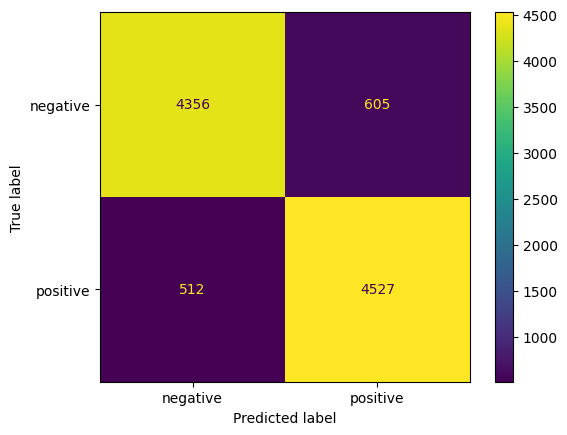

In [251]:
cm_cv = confusion_matrix(y_test_cv, lr_bow_predict, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=lr.classes_)
disp.plot()

##### For TFIDF Model

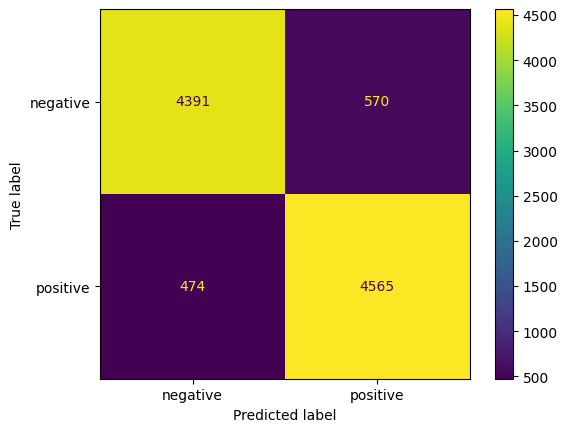

In [252]:
cm_tf = confusion_matrix(y_test_tf, lr_tfidf_predict, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tf, display_labels=lr.classes_)
disp.plot()

### Model 2: Multinomial Naive Bayes (MNB)

#### MNB - Bags of Words Model

In [253]:
# Training the Multinomial Naive Bayes model
mnb = MultinomialNB()


# Fitting the MNB for Bag of Words
mnb_bow = mnb.fit(x_train_cv, y_train_cv)
print(mnb_bow)

# Predicting the model for Bag of Words
mnb_bow_predict = mnb.predict(x_test_cv)
print(mnb_bow_predict)

MultinomialNB()
['positive' 'positive' 'negative' ... 'negative' 'negative' 'negative']


#### MNB - TFIDF Model

In [254]:
# Fitting the MNB for TFIDF features
mnb_tfidf = mnb.fit(x_train_tf, y_train_tf)
print(mnb_tfidf)

# Predicting the MNB model for TFIDF features
mnb_tfidf_predict = mnb.predict(x_test_tf)
print(mnb_tfidf_predict)

MultinomialNB()
['positive' 'positive' 'negative' ... 'positive' 'negative' 'negative']


#### MNB - Accuracy Scores for both Models

In [255]:
# Accuracy score for Bag of Words
mnb_bow_score = accuracy_score(y_test_cv, mnb_bow_predict)
print('mnb_bow_score : {:.2f}%'.format(mnb_bow_score*100))

# Accuracy score for TFIDF features
mnb_tfidf_score = accuracy_score(y_test_tf, mnb_tfidf_predict)
print('mnb_tfidf_score : {:.2f}%'.format(mnb_tfidf_score*100))

mnb_bow_score : 85.58%
mnb_tfidf_score : 86.85%


#### MNB - Confusion Matrix for both Models

##### For Bags of Words Model

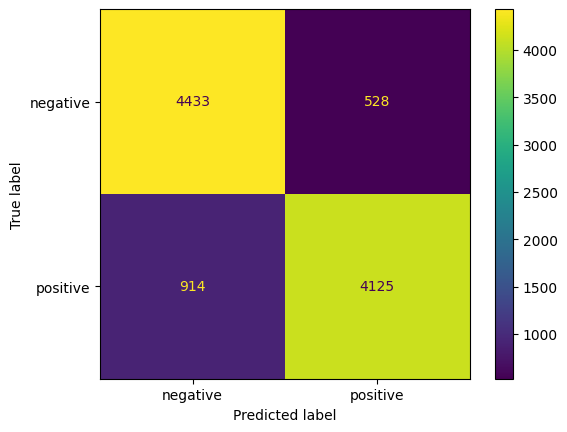

In [256]:
cm_cv_mnb = confusion_matrix(y_test_cv, mnb_bow_predict, labels=mnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_cv_mnb, display_labels = mnb.classes_)
disp.plot()

##### For TFIDF Model

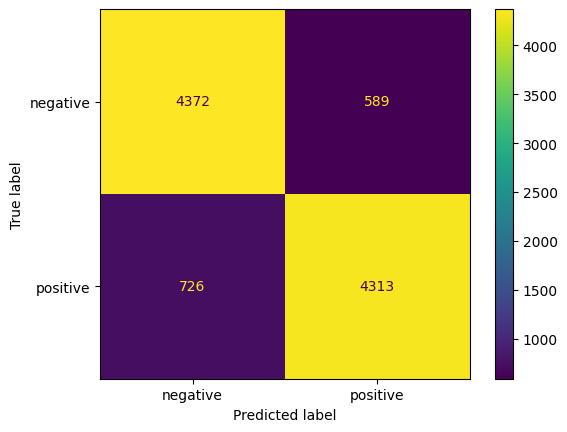

In [257]:
cm_tf_mnb = confusion_matrix(y_test_tf, mnb_tfidf_predict, labels=mnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_tf_mnb, display_labels = mnb.classes_)
disp.plot()